In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate import prepare_areal_shapefile  # Prepare data
from pyinterpolate import get_points_within_area  # Prepare data
from pyinterpolate import calculate_semivariance  # Experimental semivariogram
from pyinterpolate import RegularizedSemivariogram  # Semivariogram regularization class

import matplotlib.pyplot as plt

In [3]:
# 1. Read csv (or excel) data

df = pd.read_csv('input_data/covid wrzesien cropped.csv', sep=';', index_col='ID')
df.head()

,NAZWA,VOIVOD,1.09,14.09,30.09
ID,,,,,
201,powiat aleksandrowski,kujawsko-pomorskie,57,94,213
202,powiat brodnicki,kujawsko-pomorskie,45,52,73
203,powiat bydgoski i Bydgoszcz,kujawsko-pomorskie,336,366,501
204,powiat chełmiński,kujawsko-pomorskie,84,87,96
205,powiat golubsko-dobrzyński,kujawsko-pomorskie,10,11,16


In [24]:
# 2. Read shapefile data.

gdf = gpd.read_file('input_data/powiaty/Powiaty.shp', encoding='utf8')
gdf.set_index('ID', inplace=True)
gdf.head()

,NAZWA,VOIVOD,geometry
ID,,,
915,powiat ropczycko-sędziszowski,podkarpackie,"POLYGON ((21.69429 50.17849, 21.69440 50.17849..."
710,powiat łosicki,mazowieckie,"POLYGON ((22.72381 52.28039, 22.72379 52.28043..."
718,powiat piaseczyński,mazowieckie,"POLYGON ((21.11010 52.11317, 21.10875 52.11459..."
727,powiat sierpecki,mazowieckie,"POLYGON ((19.50876 52.86784, 19.50873 52.86795..."
730,powiat szydłowiecki,mazowieckie,"POLYGON ((20.80150 51.31374, 20.80195 51.31390..."


In [31]:
## 4. Second method: use merge
#ndf = pd.merge(gdf, df).set_index(pd.index)
##ndf.dropna()
# Kurła Merge nie działa
second_df = df.drop(['NAZWA','VOIVOD'], axis=1)

ndf = gdf.join(second_df, lsuffix='_g')
ndf.head()

,NAZWA,VOIVOD,geometry,1.09,14.09,30.09
ID,,,,,,
915,powiat ropczycko-sędziszowski,podkarpackie,"POLYGON ((21.69429 50.17849, 21.69440 50.17849...",NaN,NaN,NaN
710,powiat łosicki,mazowieckie,"POLYGON ((22.72381 52.28039, 22.72379 52.28043...",NaN,NaN,NaN
718,powiat piaseczyński,mazowieckie,"POLYGON ((21.11010 52.11317, 21.10875 52.11459...",NaN,NaN,NaN
727,powiat sierpecki,mazowieckie,"POLYGON ((19.50876 52.86784, 19.50873 52.86795...",NaN,NaN,NaN
730,powiat szydłowiecki,mazowieckie,"POLYGON ((20.80150 51.31374, 20.80195 51.31390...",NaN,NaN,NaN


In [6]:
# That's the basics, it's up to you which method you'll choose
# Just in case you may visualize your geodatframe:

,NAZWA,VOIVOD,geometry,1.09,14.09,30.09
0,powiat kościerski,pomorskie,"POLYGON ((17.90305 53.83492, 17.90256 53.83501...",46,70,148
1,powiat giżycki,warmińsko-mazurskie,"POLYGON ((21.88723 54.08715, 21.88739 54.08721...",35,40,51
2,powiat mrągowski,warmińsko-mazurskie,"POLYGON ((21.36273 53.62548, 21.36168 53.62565...",14,15,21
3,powiat inowrocławski,kujawsko-pomorskie,"POLYGON ((18.05625 52.86959, 18.05643 52.86995...",53,71,142
4,powiat brodnicki,kujawsko-pomorskie,"POLYGON ((19.34407 53.20328, 19.34392 53.20343...",45,52,73


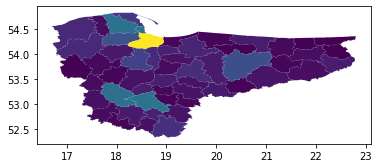

In [7]:
ndf.plot(column='14.09', cmap='viridis')
ndf.head()

# Droping columns with polish characters

In [42]:
second_ndf = ndf.drop(['NAZWA','VOIVOD'], axis=1)
second_ndf = second_ndf.dropna()

# And store it as a new file (commented below)

In [43]:
second_ndf.to_file('./input_data/covid_wrzesien_polnoc.shp')

In [44]:
second_ndf.describe()

,1.09,14.09,30.09
count,55.000000,55.000000,55.000000
mean,88.054545,106.000000,168.000000
std,135.704256,159.763251,233.590097
min,0.000000,3.000000,3.000000
25%,21.000000,25.000000,48.500000
50%,45.000000,54.000000,82.000000
75%,88.000000,110.500000,195.500000
max,852.000000,1013.000000,1424.000000


## 1) Prepare areal and point data

In [45]:
point_data = './input_data/population_data/population_centroids_poland.shp'
areal_data = './input_data/covid_wrzesien_polnoc.shp'

# The important thing before analysis is to check if crs of areal data and point data are the same

areal_crs = gpd.read_file(areal_data).crs
point_support_crs = gpd.read_file(point_data).crs

areal_crs == point_support_crs

False

In [46]:
# Those two data have different Managing Projections. We need to change it

areal_new_crs = gpd.read_file(areal_data).to_crs(point_support_crs)
areal_new_crs.to_file('./input_data/covid_wrzesien_polnoc_2180.shp')
areal_data = './input_data/covid_wrzesien_polnoc_2180.shp'

areal_crs = gpd.read_file(areal_data).crs
point_support_crs = gpd.read_file(point_data).crs

areal_crs == point_support_crs

True

In [47]:
# We need to know:
# - id column name of areal units,
# - value column name of areal units (usually aggregates),
# - value column name of point support units (usually population)

# Let's check it quickly with geopandas

areal = gpd.read_file(areal_data)
areal.head()

,ID,1.09,14.09,30.09,geometry
0,1107,46.0,70.0,148.0,"POLYGON ((427834.122 663922.497, 427801.950 66..."
1,1406,35.0,40.0,51.0,"POLYGON ((688779.348 695272.665, 688789.569 69..."
2,1411,14.0,15.0,21.0,"POLYGON ((656202.995 642663.759, 656132.391 64..."
3,207,53.0,71.0,142.0,"POLYGON ((436493.723 556422.695, 436506.363 55..."
4,202,45.0,52.0,73.0,"POLYGON ((522975.340 593170.192, 522964.900 59..."


In [48]:
# From areal file we are interested in variable deaths (value) and ID (id)
# Now check point support data
# TOT - Total population

point = gpd.read_file(point_data)
point.head()

,TOT,geometry
0,0,POINT (445700.430 775061.580)
1,13,POINT (449649.816 774784.622)
2,1270,POINT (454573.872 774546.994)
3,95,POINT (457672.822 774072.742)
4,0,POINT (425378.686 772864.038)


In [49]:
# Column TOT is interesting from our perspective
# Now prepare data for further processing

areal_id = 'ID'
areal_val = '14.09'
points_val = 'TOT'

areal_data_prepared = prepare_areal_shapefile(areal_data, areal_id, areal_val)

In [50]:
# Check how prepared areal data looks like

areal_data_prepared[0]

array([1107, <shapely.geometry.polygon.Polygon object at 0x7f0aa4313b10>,
       434792.63211455947, 687469.7909778056, 70.0], dtype=object)

### Clarification:

Every areal dataset is passed as an array of:

[area id, area geometry (polygon), areal centroid x (lon), areal centroid y (lat), value]

In [51]:
points_in_area = get_points_within_area(areal_data, point_data, areal_id_col_name=areal_id,
                                        points_val_col_name=points_val)

In [52]:
# Check how prepared point data looks like

points_in_area[0]

array([1112.0,
       array([[4.49649816e+05, 7.74784622e+05, 1.30000000e+01],
       [4.54573872e+05, 7.74546994e+05, 1.27000000e+03],
       [4.57672822e+05, 7.74072742e+05, 9.50000000e+01],
       [4.34132306e+05, 7.73217942e+05, 5.81000000e+02],
       [4.39115084e+05, 7.73011892e+05, 1.99000000e+02],
       [4.44027632e+05, 7.72564517e+05, 7.50000000e+02],
       [4.48983771e+05, 7.71947376e+05, 2.57400000e+03],
       [4.53943595e+05, 7.71324042e+05, 1.21200000e+03],
       [4.58775918e+05, 7.70575412e+05, 6.34600000e+03],
       [4.33469881e+05, 7.68864048e+05, 1.92600000e+03],
       [4.43389339e+05, 7.67616758e+05, 1.94300000e+03],
       [4.48349167e+05, 7.66993362e+05, 1.99000000e+03],
       [4.53309065e+05, 7.66370130e+05, 2.74500000e+03],
       [4.58269037e+05, 7.65747062e+05, 2.90200000e+03],
       [4.73064428e+05, 7.63569749e+05, 6.22000000e+02],
       [4.76799027e+05, 7.61514013e+05, 0.00000000e+00],
       [4.42754940e+05, 7.62662657e+05, 9.23000000e+02],
       [4

### Clarification:

Every point support dataset is passed as an array of:

[area id, array of: [lon, lat, value]]

## 2) Set semivariogram parameters.

Now we must set parameters for areal semivariogram AND point semivariogram. It is very important to understand data well to set them properly, that's why you should always check experimental semivariograms of those datasets to understand how data behaves. We do it for prepared areal and point datasets.

100%|██████████| 10/10 [00:00<00:00, 3564.16it/s]


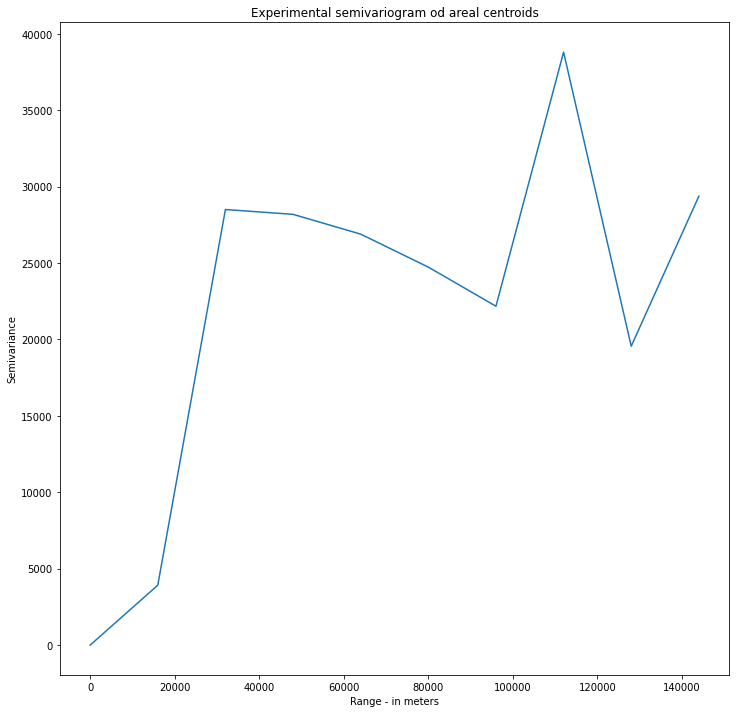

In [53]:
# Check experimental semivariogram of areal data - this cell may be run multiple times 
# before you find optimal parameters

maximum_range = 160000
step_size = 8000
lags = np.arange(0, maximum_range, step_size * 2)

dt = areal_data_prepared[:, 2:]  # x, y, val
exp_semivar = calculate_semivariance.calculate_semivariance(data=dt,
                                                           lags=lags,
                                                           step_size=step_size)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

100%|██████████| 5/5 [00:00<00:00, 33.98it/s]


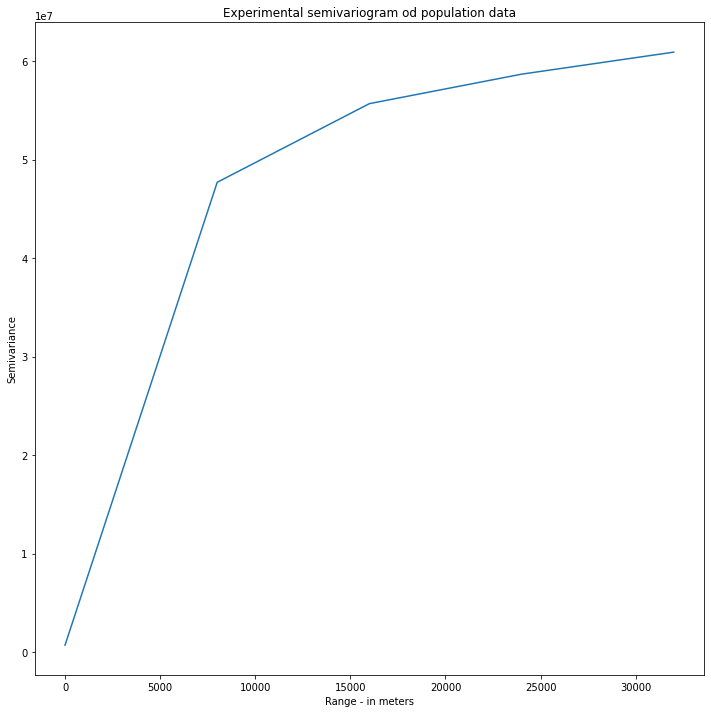

In [54]:
# Check experimental semivariogram of point data - this cell may be run multiple times 
# before you find optimal parameters

def build_point_array(points):
    a = None

    for rec in points:
        if a is None:
            a = rec.copy()
        else:
            a = np.vstack((a, rec))

    return a

maximum_point_range = 40000
step_size_points = 4000
lags_points = np.arange(0, maximum_point_range, step_size_points * 2)


pt = build_point_array(points_in_area[:, 1])  # x, y, val
exp_semivar = calculate_semivariance.calculate_semivariance(data=pt,
                                                           lags=lags_points,
                                                           step_size=step_size_points)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od population data')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

After few adjustements we have prepared semivariogram parameters for areal and point support data. The next step is to create RegularizedSemivariogram model. We have mutiple parameters to choose and at the beginning it is hard to find the best fit, so try to avoid multiple loops because it is a time-consuming operation.

The program is designed to first **fit()** the model and later to **transform()** it.

When you **fit()** a model you have multiple parameters to control: 
* areal_data: areal data prepared with the function prepare_areal_shapefile(), where data is a numpy array
    in the form: [area_id, area_geometry, centroid coordinate x, centroid coordinate y, value],
* areal_lags: list of lags between each distance,
* areal_step_size: step size between each lag, usually it is a half of distance between lags,
* point_support_data: point support data prepared with the function get_points_within_area(), where data is
    a numpy array in the form: [area_id, [point_position_x, point_position_y, value]],
* ranges: (int) number of ranges to test during semivariogram fitting. More steps == more accurate nugget
    and range prediction, but longer calculations,
* weighted_lags: (bool) lags weighted by number of points; if True then during semivariogram fitting error
    of each model is weighted by number of points for each lag. In practice it means that more reliable data
    (lags) have larger weights and semivariogram is modeled to better fit to those lags,
* store_models: (bool) if True then experimental, regularized and theoretical models are stored in lists
    after each iteration. It is important for a debugging process.

We set ranges to 64, then we will weight lags and we do not store semivariograms and semivariogram models.

After fitting we perform **transform()**. This function has few parameters to control regularization process, but we leave them as default with one exception: we set max_iters parameter to 5.

This process of fitting and transforming takes some time, so it's good idea to run it and do something else...

## 3) Regularize semivariogram

In [55]:
reg_mod = RegularizedSemivariogram()

In [56]:
reg_mod.fit(areal_data=areal_data_prepared,
            areal_lags=lags, areal_step_size=step_size,
            point_support_data=points_in_area, ranges=32, weighted_lags=True, store_models=False)

100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


#### NOTE:

Probably something is wrong with our model and it is not well regularized by the algorithm. This may mean that our data is not spatially corellated (e.g. number of accidencts and population at risk are not correlated in space). We can check initial semivariograms to test this assumption.

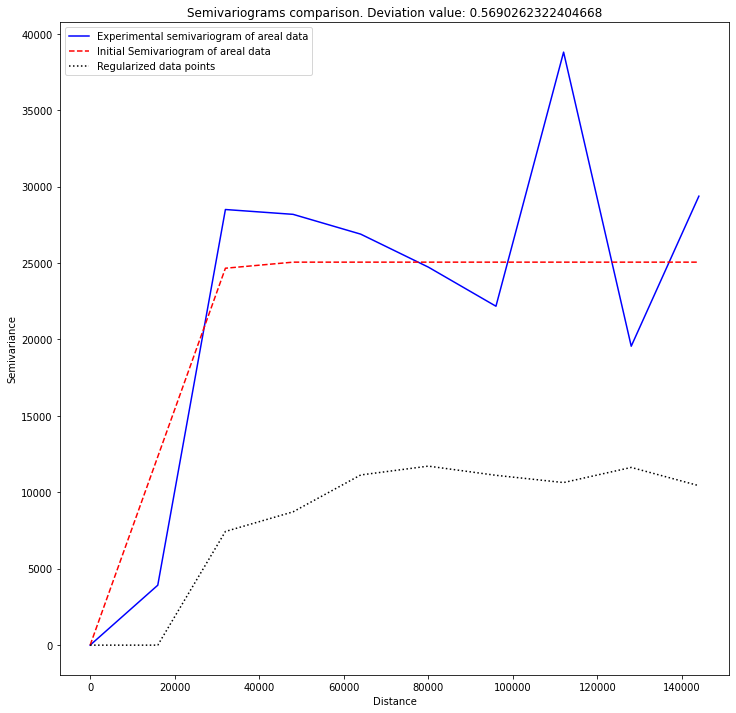

In [57]:
# Check initial experimental, theoretical and regularized semivariograms

lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize=(12, 12))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], color='b')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.initial_regularized_model, color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.initial_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

#### NOTE:

There's a large relative difference between regularized semivariance and theoretical semivariogram of areal data. What's more important: sill is reached approx. at 25 km distance... So there is a problem of scale: spatial correlation potentially exists but at much smaller scales than we are able to observe.

Anyway, we perfom the rest of tutorial with this dataset*.

(*) New tutorials with different datasets and scenarios will be released in November / December 2020.

In [58]:
reg_mod.transform(max_iters=5)

100%|██████████| 55/55 [00:15<00:00,  3.65it/s]


**NOTE:**

Operation is slow in the beta version of library so try to find some different task to do when process runs.

## 4) Visualize and check semivariogram

### Clarification:

Process is fully automatic but we can check how it baheaved through each iteration. We can analyze deviation change (most important variable, mean absolute difference between regularized and theoretical models) with build-in method but if you are more interested in the algorithm stability you can analyze weight change over each iteration too.

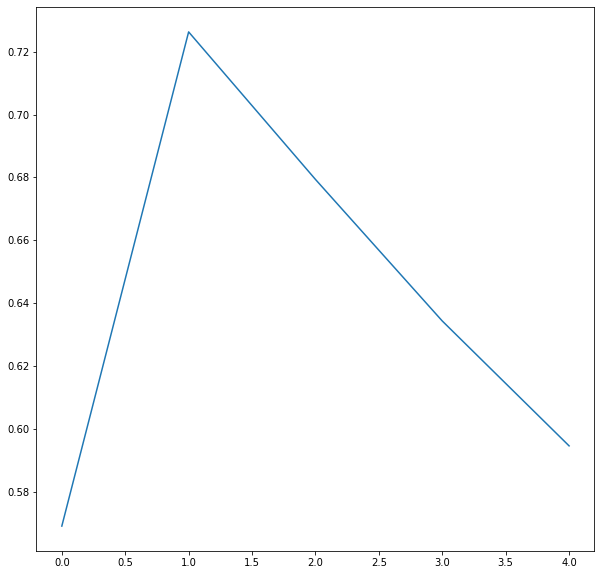

In [59]:
# First analyze deviation

plt.figure(figsize=(10, 10))
plt.plot(reg_mod.deviations)
plt.show()

### Clarification:

Deviation is worse than initial deviation after the first step of regularization and then it sharply decrease. It means that our problem is not best suited for Poisson Kriging - we should see decrease of deviation from the beginning. The reason of this fact will be better visible in semivariograms comparison in the cell below.

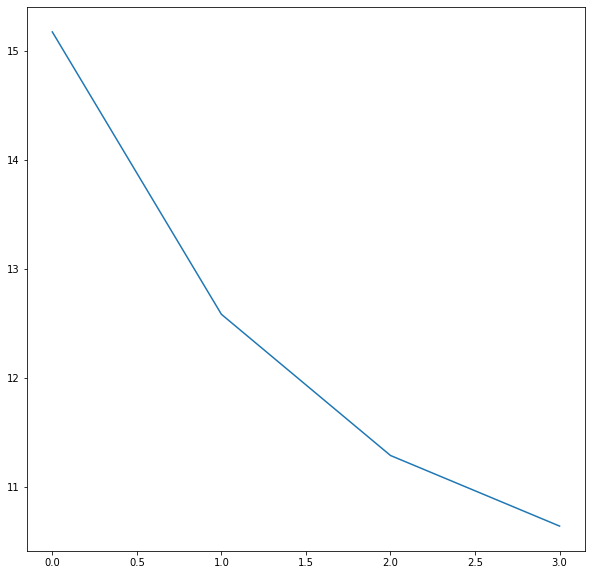

In [60]:
# Check weights - it is important to track problems with algorithm, esepcially if sum of weights is oscillating
# then it may be a sign of problems with data, model or (hopefully not!) algorithm itself.

weights = reg_mod.weights
weights = [sum(w) for w in weights]

plt.figure(figsize=(10,10))
plt.plot(weights)
plt.show()

#### NOTE:

Weights are smaller with each iteration. It is normal behavior of algorithm. Unfortunately, weights should start from the 1 and then they should be smaller.

#### NOTE:

The most important part is to compare semivariograms! You can see that Optimized Model is equal to Initial Semivariogram of areal data: our model is not better than normal kriging of areal centroids.

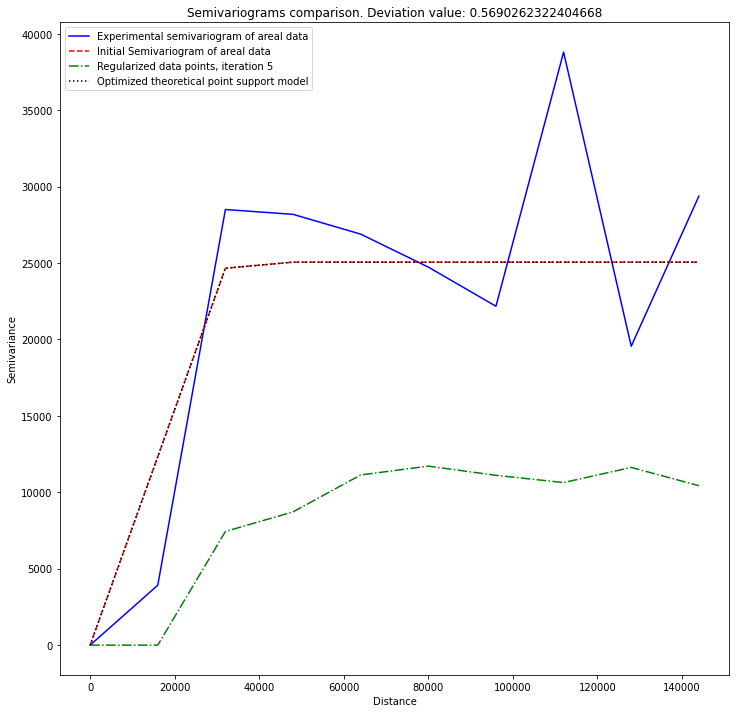

In [61]:
reg_mod.show_semivariograms()